# Toronto Optimization

In this notebook, I optimize constructed housing in the city of Toronto under a variety of conditions: 
- in the "scenarios" section, I focus on demonstrating the utility of different constraint
- in the "MOO" section, I do multi-objective optimization with different objective functions

# Setup

In [1]:
import sys
import json
import math
import pickle
from pathlib import Path
sys.path.append("../../../")

import numpy as np
import pandas as pd
import geopandas as gpd
import time
from shapely import Point

from urbanopt import PathwayOptimizer

In [2]:
import lonboard
from lonboard import Map, ScatterplotLayer, PolygonLayer, viz
from lonboard.colormap import apply_categorical_cmap, apply_continuous_cmap
# from palettable.tableau import Tableau_10 as palette
from palettable.cartocolors.qualitative import Bold_5 as palette
from palettable.cmocean.sequential import Amp_18

from matplotlib import pyplot as plt

In [3]:
working_dir = Path.cwd()

results_dir = working_dir / "results"
results_dir.mkdir(parents=True, exist_ok=True)

pathways = gpd.read_parquet(working_dir/"input_data"/f"{working_dir.stem}_pathways.parquet")
census_data_2021 = gpd.read_parquet(working_dir/"input_data"/f"{working_dir.stem}_2021_pruned_census.parquet")
census_data_2016 = gpd.read_parquet(working_dir/"input_data"/f"{working_dir.stem}_2016_pruned_census.parquet")

proj_crs = "EPSG:3347"

```
char_ids =set(
    list(range(1,8)) + # Population
    list(range(41, 111)) + # Household (structure, family size) metrics
    list(range(242, 383)) + # Income metrics
    list(range(1414, 1500)) # Private Household metrics 
)
```

## Utilities

In [4]:
def lonboard_vis(selected_pids, data, cmap, layer_kwargs = None, sample_frac=0.5, map_kwargs=None): 
    """Plot selected pathways using lonboard."""
    layer_kwargs = layer_kwargs or {}
    map_kwargs = map_kwargs or {}

    plot_gdf = data[data["pid"].isin(selected_pids)].copy()
    plot_gdf = plot_gdf.sample(frac=sample_frac, random_state=42)
    
    counts = plot_gdf["label"].value_counts()
    plot_gdf["_count"] = plot_gdf["label"].map(counts)
    plot_gdf = plot_gdf.sort_values("_count", ascending=False).drop(columns="_count")

    # Converting to centroids
    jitter = 4
    
    plot_gdf = plot_gdf.to_crs("EPSG:3347")
    plot_gdf["geometry"] = plot_gdf.geometry.centroid.apply(
        lambda pt: Point(
            pt.x + np.random.uniform(-jitter, jitter),
            pt.y + np.random.uniform(-jitter, jitter)
        )
    )
    plot_gdf = plot_gdf.to_crs("EPSG:4326")

    # Coloring
    labels = sorted(data["label"].unique())
    label_to_int = {label: i for i, label in enumerate(labels)}
    int_cmap = {label_to_int[l]: c for l, c in cmap.items()}
    
    centroid_colors = apply_categorical_cmap(
        values=plot_gdf["label"].map(label_to_int),
        cmap=int_cmap
    )

    # Plotting
    default_layer_kwargs = {
        "radius_min_pixels": 2,
        "radius_scale": 5,
        "radius_units": "meters",
        "opacity": 0.25,
    }
    layer_kwargs = {**default_layer_kwargs, **(layer_kwargs or {})}
    centroid_layer = ScatterplotLayer.from_geopandas(
        plot_gdf,
        get_fill_color=centroid_colors,
        **layer_kwargs
    )

    default_map_kwargs = {
        "basemap_style": lonboard.basemap.CartoBasemap.DarkMatterNoLabels,
    }
    map_kwargs = {**default_map_kwargs, **(map_kwargs or {})}
    
    return Map(
        [centroid_layer], 
        # parameters=parameters,
        **map_kwargs
    )

In [5]:
def quick_vis(nimby_pids, pathways, cmap):
    import matplotlib.pyplot as plt

    # Filter and group
    filtered = pathways[pathways['pid'].isin(nimby_pids)]
    grouped = filtered.groupby('label')['opportunity'].agg(['count', 'sum']).reset_index()

    # Sort by 'count' and 'sum'
    count_sorted = grouped.sort_values(by='count', ascending=False)
    sum_sorted = grouped.sort_values(by='sum', ascending=False)

    # Normalize colors
    count_colors = [tuple(c/255 for c in cmap[label]) for label in count_sorted['label']]
    sum_colors = [tuple(c/255 for c in cmap[label]) for label in sum_sorted['label']]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

    # Plot count
    ax1.bar(count_sorted['label'], count_sorted['count'], color=count_colors)
    ax1.set_title('Pathway counts')
    ax1.grid(False)

    # Plot sum
    ax2.bar(sum_sorted['label'], sum_sorted['sum'], color=sum_colors)
    ax2.set_title('Opportunity')
    ax2.grid(False)

    plt.tight_layout()
    plt.show()

In [6]:
def quick_vis_tri(nimby_pids, pathways, cmap):
    import matplotlib.pyplot as plt

    # Filter and group
    filtered = pathways[pathways['pid'].isin(nimby_pids)]
    grouped = filtered.groupby('label').agg({
        'opportunity': ['count', 'sum'],
        'cost_emb': 'sum'
    }).reset_index()
    grouped.columns = ['label', 'count', 'sum_opportunity', 'sum_cost']
    
    label_order = ["bment", "vsplit", "adu", "p2lo"]  # your desired order

    # Reindex grouped to follow label_order
    grouped = grouped.set_index("label").reindex(label_order).reset_index()

    # # Sort for each subplot
    # count_sorted = grouped.sort_values(by='count', ascending=False)
    # sum_sorted = grouped.sort_values(by='sum_opportunity', ascending=False)
    # cost_sorted = grouped.sort_values(by='sum_cost', ascending=False)

    # Normalize colors
    # count_colors = [tuple(c / 255 for c in cmap[label]) for label in count_sorted['label']]
    # sum_colors = [tuple(c / 255 for c in cmap[label]) for label in sum_sorted['label']]
    # cost_colors = [tuple(c / 255 for c in cmap[label]) for label in cost_sorted['label']]
    colors = [tuple(c / 255 for c in cmap[label]) for label in grouped['label']]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10.5, 3), dpi=150)

    ax1.bar(grouped['label'], grouped['count'], color=colors)
    ax1.set_title('Pathway counts')
    ax1.grid(False)

    ax2.bar(grouped['label'], grouped['sum_opportunity'], color=colors)
    ax2.set_title('Opportunity (ppl)')
    ax2.grid(False)

    ax3.bar(grouped['label'], grouped['sum_cost']/1e9, color=colors)
    ax3.set_title('Embodied Carbon (Mt)')
    ax3.grid(False)

    plt.tight_layout()
    plt.show()


In [7]:
def sjoin_greatest_intersection(
    target_df: gpd.GeoDataFrame,
    source_df: gpd.GeoDataFrame,
    variables: list[str],
) -> gpd.GeoDataFrame:
    """Join variables from source_df based on the largest intersection. In case of a tie it picks the first one.

    From https://pysal.org/tobler/_modules/tobler/area_weighted/area_join.html#area_join

    Args:
        source_df (geopandas.GeoDataFrame): GeoDataFrame containing source values.
        target_df (geopandas.GeoDataFrame): GeoDataFrame containing target values.
        variables (str or list-like): Column(s) in `source_df` dataframe for variable(s) to be joined.

    Returns:
        geopandas.GeoDataFrame: The `target_df` GeoDataFrame with joined variables as additional columns.

    """
    if not pd.api.types.is_list_like(variables):
        variables = [variables]

    for v in variables:
        if v in target_df.columns:
            msg = f"Column '{v}' already present in target_df."
            raise ValueError(msg)

    target_df = target_df.copy()
    target_ix, source_ix = source_df.sindex.query(
        target_df.geometry,
        predicate="intersects",
    )
    areas = (
        target_df.geometry.values[target_ix]  # noqa: PD011
        .intersection(source_df.geometry.values[source_ix])  # noqa: PD011
        .area
    )

    main = []
    for i in range(len(target_df)):  # vectorise this loop?
        mask = target_ix == i
        if np.any(mask):
            main.append(source_ix[mask][np.argmax(areas[mask])])
        else:
            main.append(np.nan)

    main = np.array(main, dtype=float)
    mask = ~np.isnan(main)

    for v in variables:
        arr = np.empty(len(main), dtype=object)
        arr[mask] = source_df[v].to_numpy()[main[mask].astype(int)]
        try:
            arr = arr.astype(source_df[v].dtype)
        except TypeError:
            warnings.warn(
                f"Cannot preserve dtype of '{v}'. Falling back to `dtype=object`.",
            )
        target_df[v] = arr

    return target_df

In [8]:
from typing import Self
class SpatialGraph:
    """A graph created from geodata.

    Typically created using SpatialGraph.create_from_geoseries()

    Supported predicates for building the graph are:
        - `intersects`
        - `overlaps`

    Attributes:
        adj_list: The generated graph. Stored as an adjacency list ({id: {neighbour ids}}).
            ids correspond to indices in the original geoseries.
    """

    def __init__(self, adj_list: dict):
        """Create SpatialGraph object.

        Args:
            adj_list (dict): The graph of adjacent polygons in an adjaceny list form ({id: {neighbour ids}}).
        """
        self.adj_list = adj_list

    @classmethod
    def create_from_geoseries(
        cls,
        gs: gpd.GeoSeries,
        predicate: str = "intersects",
    ) -> Self:
        """Create a SpatialGraph object from a geoseries.

        Args:
            gs (gpd.GeoSeries): Input geoseries. Preferrably in a projected crs
            predicate (str, optional): Binary predicate to use to determine neighbouring geometries.
                Defaults to "intersects"
        """
        gs = gs.copy()

        original_index = gs.index.to_list()
        sindex = gs.sindex

        graph = {}
        for idx, poly in gs.items():
            neighbour_sidxs = sindex.query(poly, predicate)
            neighbours = {original_index[i] for i in neighbour_sidxs}

            # Some predicates will produce self-edges
            if idx in neighbours:
                neighbours.remove(idx)

            graph[idx] = neighbours

        return SpatialGraph(adj_list=graph)

    def create_connected_components_map(self) -> dict:
        """Generates an {id: cc_id} map.

        cc_id is the connected component to which a given polygon id belongs.

        Returns:
            dict: The {id: cc_id} map
        """
        graph = self.adj_list

        mapper = {}

        group_id = 0
        for v in graph:
            if v not in mapper:
                connected_component = self.get_connected(v)
                mapper.update({idx: group_id for idx in connected_component})
                group_id += 1

        return mapper

    def get_connected(self, root: int) -> set[int]:
        """Given a root node, generates a list of connected nodes with DFS."""
        stack = [root]
        visited = set()

        while len(stack) > 0:
            v = stack.pop(-1)
            if v not in visited:
                visited.add(v)
                stack = stack + list(self.adj_list[v])

        return visited


In [9]:
def generate_doubles(step_size: float) -> list[float]:
    """Generate a list of two points that sum to 1."""
    n = int(1 / step_size)
    doubles = []

    for i in range(n + 1):
        j = n - i

        w1 = i * step_size
        w2 = j * step_size

        doubles.append([w1, w2])

    return doubles

In [10]:
def weighted_median(values, weights):
    """Compute the weighted median of a set of values."""
    sorter = np.argsort(values)
    values = np.array(values)[sorter]
    weights = np.array(weights)[sorter]

    cumulative_weight = np.cumsum(weights)
    cutoff = weights.sum() / 2.0
    return values[np.searchsorted(cumulative_weight, cutoff)]

# Scenarios
Optimizing constraint-based scenarios with a single, linear objective function.

In [11]:
obj_weights = {
    "cost_emb": 1.0
}

## Base

### Setup

In [40]:
opt = PathwayOptimizer(pathways)
opt.build_variables()
opt.set_objective(obj_weights)

In [41]:
# Baseline constraints
opt.add_opportunity_constraints(1100000, ">=", tag="min_opp") #Must grow by 1.1 million people
opt.add_mutual_exclusion("p2lo", tag="mutal_exclusion") #Converting parking lots means you can't do other things in that area

<MConstr (2433,)>

In [43]:
opt.debug_model()

Gurobi Model Debug Info
- Variables: 843297
- Constraints: 2434
- Objective set: True
- Model status: 1


### Solve

In [44]:
opt.solve(verbose=False)
opt.get_solution_summary()

Optimization Summary
  Objective Value   : 3247782332.39
  Total Opportunity: 1100001.00
  Solve Time        : 2.951 sec
  Selected Pathways : 212931


{'objective_value': 3247782332.386051,
 'cost_column_sums': {'cost_emb': np.float64(3247782332.38605),
  'cost_bus': np.float64(43887413.10884028),
  'cost_train': np.float64(419094517.0895012),
  'cost_transit': np.float64(882076447.2878428),
  'cost_access': np.float64(136702.1143617309)},
 'total_opportunity': np.float64(1100001.0000000005),
 'solve_time': 2.9509999752044678,
 'selected_count': 212931}

In [25]:
base_pids = opt.get_selected_pids()

cmap = {
    "bment": palette.colors[3],
    "vsplit": palette.colors[2],
    "adu": palette.colors[1],
    "p2lo": palette.colors[0]
}

lonboard_vis(base_pids,
             pathways,
             cmap,
             sample_frac=0.2, 
             layer_kwargs={
                 "opacity":0.4,
                 "radius_scale": 1,
                 # "radius_max_pixels": 2,
                 # "radius_min_pixels": 2,
             },
             map_kwargs={
                 "_height":800
             }
            )

Map(basemap_style=<CartoBasemap.DarkMatterNoLabels: 'https://basemaps.cartocdn.com/gl/dark-matter-nolabels-gl-…

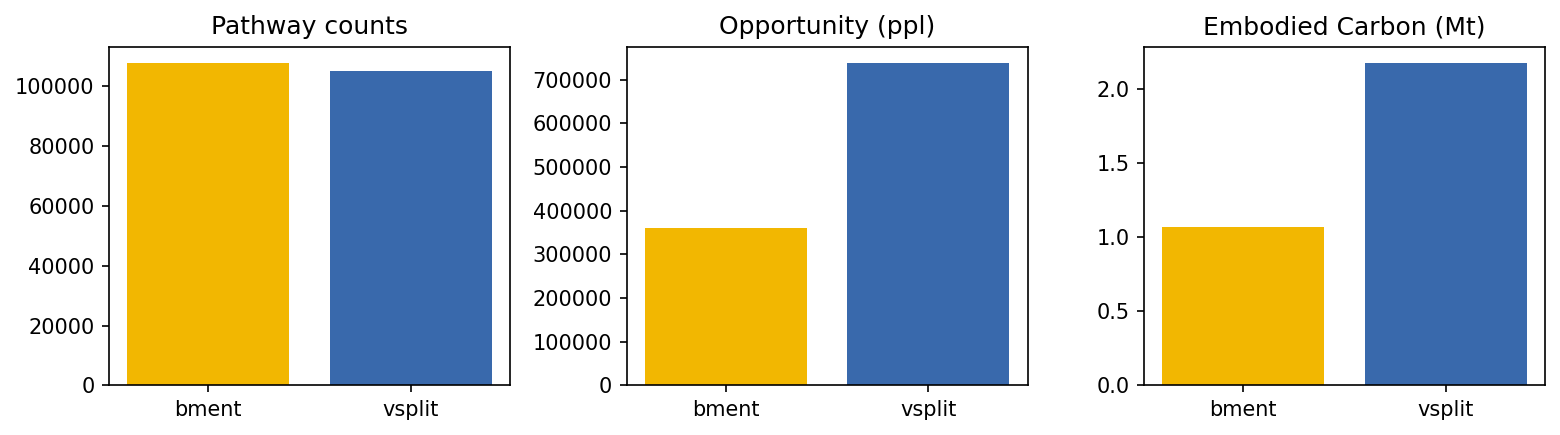

In [26]:
quick_vis_tri(base_pids, pathways, cmap)

In [27]:
total_carbon = pathways[pathways["pid"].isin(base_pids)]["cost_emb"].sum()/1e9
print(f"Embodied Carbon: {total_carbon:.4} Mt")

Embodied Carbon: 3.248 Mt


In [28]:
with (results_dir / "base_pids.pkl").open("wb") as f:
    pickle.dump(base_pids, f)

## Generic
Just base + everything can only grow by up to 2x

### Setup

In [45]:
opt = PathwayOptimizer(pathways)
opt.build_variables()
opt.set_objective(obj_weights)

In [46]:
# Baseline constraints
opt.add_opportunity_constraints(1100000, ">=", tag="min_opp") #Must grow by 1.1 million people
opt.add_mutual_exclusion("p2lo", tag="mutal_exclusion") #Converting parking lots means you can't do other things in that area

<MConstr (2433,)>

In [47]:
# Generic Constraints
cdata = census_data_2021[["1", "geometry"]].copy() # 1: 2021 population, 243: Median HH income

cdata["limit"] = cdata["1"] * 2

opt.add_opportunity_constraints(cdata["limit"].to_list(), "<=", cdata["geometry"].to_list(), tag="doubling");

In [54]:
opt.debug_model()

Gurobi Model Debug Info
- Variables: 843297
- Constraints: 6176
- Objective set: True
- Model status: 2


### Solve

In [48]:
opt.solve(verbose=False)
opt.get_solution_summary()

Optimization Summary
  Objective Value   : 3248341009.05
  Total Opportunity: 1100001.00
  Solve Time        : 4.139 sec
  Selected Pathways : 213266


{'objective_value': 3248341009.0490594,
 'cost_column_sums': {'cost_emb': np.float64(3248341009.049057),
  'cost_bus': np.float64(43853013.733700626),
  'cost_train': np.float64(419467787.0644774),
  'cost_transit': np.float64(882788587.8626555),
  'cost_access': np.float64(136854.32253515357)},
 'total_opportunity': np.float64(1100000.9999999998),
 'solve_time': 4.138999938964844,
 'selected_count': 213266}

In [49]:
opt.get_solution_summary()

{'objective_value': 3248341009.0490594,
 'cost_column_sums': {'cost_emb': np.float64(3248341009.049057),
  'cost_bus': np.float64(43853013.733700626),
  'cost_train': np.float64(419467787.0644774),
  'cost_transit': np.float64(882788587.8626555),
  'cost_access': np.float64(136854.32253515357)},
 'total_opportunity': np.float64(1100000.9999999998),
 'solve_time': 4.138999938964844,
 'selected_count': 213266}

In [50]:
generic_pids = opt.get_selected_pids()

cmap = {
    "bment": palette.colors[3],
    "vsplit": palette.colors[2],
    "adu": palette.colors[1],
    "p2lo": palette.colors[0]
}

lonboard_vis(generic_pids,
             pathways,
             cmap,
             sample_frac=0.2, 
             layer_kwargs={
                 "opacity":0.2,
                 "radius_scale": 1,
                 # "radius_max_pixels": 2,
                 # "radius_min_pixels": 2,
             },
             map_kwargs={
                 "_height":800
             }
            )

Map(basemap_style=<CartoBasemap.DarkMatterNoLabels: 'https://basemaps.cartocdn.com/gl/dark-matter-nolabels-gl-…

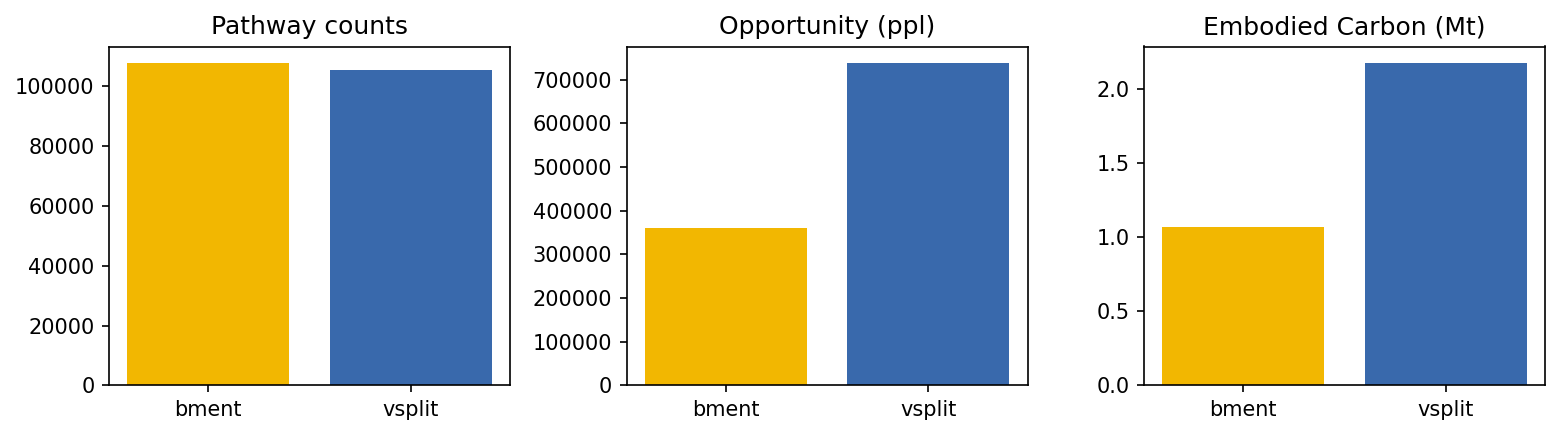

In [51]:
quick_vis_tri(generic_pids, pathways, cmap)

In [52]:
total_carbon = pathways[pathways["pid"].isin(generic_pids)]["cost_emb"].sum()/1e9
print(f"Embodied Carbon: {total_carbon:.4} Mt")

Embodied Carbon: 3.248 Mt


In [53]:
with (results_dir / "generic_pids.pkl").open("wb") as f:
    pickle.dump(generic_pids, f)

## NIMBY
In this scenario, we constrain the top 30% of areas by median household income to minmal growth (10%). Every other area can go up to *double* its current population.

### Setup

In [55]:
opt = PathwayOptimizer(pathways)
opt.build_variables()
opt.set_objective(obj_weights)

In [56]:
# Baseline constraints
opt.add_opportunity_constraints(1100000, ">=", tag="min_opp") #Must grow by 1.1 million people
opt.add_mutual_exclusion("p2lo", tag="mutal_exclusion") #Converting parking lots means you can't do other things in that area

<MConstr (2433,)>

In [79]:
# NIMBY Constraints
cdata = census_data_2021[["1", "243", "geometry"]].copy() # 1: 2021 population, 243: Median HH income
cdata["243"] = cdata["243"].fillna(0)
cdata = cdata.sort_values("243")
cdata["ptile"] = cdata["243"].rank(pct=True)

top = cdata[cdata["ptile"] >= 0.7].copy()
bottom = cdata[cdata["ptile"] < 0.7].copy()

top["limit"] = top["1"]*0.1 # only 10% of existing population
bottom["limit"] = bottom["1"] # double existing population

opt.add_opportunity_constraints(top["limit"].to_list(), "<=", top["geometry"].to_list(), tag="top30");
opt.add_opportunity_constraints(bottom["limit"].to_list(), "<=", bottom["geometry"].to_list(), tag="bottom30");

In [80]:
top.to_parquet("top30.parquet")

In [81]:
top

,1,243,geometry,ptile,limit
828,783.0,109000.0,"POLYGON ((-79.41221 43.67033, -79.41317 43.670...",0.703768,78.3
739,393.0,109000.0,"POLYGON ((-79.45393 43.6646, -79.45374 43.6641...",0.703768,39.3
3421,594.0,109000.0,"POLYGON ((-79.48536 43.65908, -79.48819 43.658...",0.703768,59.4
1173,638.0,109000.0,"POLYGON ((-79.50531 43.59547, -79.50559 43.595...",0.703768,63.8
1092,445.0,109000.0,"POLYGON ((-79.41918 43.64706, -79.41982 43.646...",0.703768,44.5
...,...,...,...,...,...
1745,455.0,432000.0,"POLYGON ((-79.39398 43.72267, -79.39356 43.721...",0.998931,45.5
2095,462.0,440000.0,"POLYGON ((-79.41369 43.69914, -79.41309 43.697...",0.999198,46.2
2116,430.0,456000.0,"POLYGON ((-79.40741 43.69654, -79.40705 43.695...",0.999466,43.0
2035,549.0,476000.0,"POLYGON ((-79.37831 43.68603, -79.37834 43.685...",0.999733,54.9


### Solve

In [58]:
opt.solve(verbose=False)
opt.get_solution_summary()

Optimization Summary
  Objective Value   : 5432811614.87
  Total Opportunity: 1100011.50
  Solve Time        : 23.419 sec
  Selected Pathways : 258081


{'objective_value': 5432811614.866856,
 'cost_column_sums': {'cost_emb': np.float64(5432811614.866845),
  'cost_bus': np.float64(44481047.24358481),
  'cost_train': np.float64(485414370.94821054),
  'cost_transit': np.float64(1015309789.1400062),
  'cost_access': np.float64(157191.8515892972)},
 'total_opportunity': np.float64(1100011.5000000002),
 'solve_time': 23.418999910354614,
 'selected_count': 258081}

In [59]:
opt.get_solution_summary()

{'objective_value': 5432811614.866856,
 'cost_column_sums': {'cost_emb': np.float64(5432811614.866845),
  'cost_bus': np.float64(44481047.24358481),
  'cost_train': np.float64(485414370.94821054),
  'cost_transit': np.float64(1015309789.1400062),
  'cost_access': np.float64(157191.8515892972)},
 'total_opportunity': np.float64(1100011.5000000002),
 'solve_time': 23.418999910354614,
 'selected_count': 258081}

In [60]:
nimby_pids = opt.get_selected_pids()

cmap = {
    "bment": palette.colors[3],
    "vsplit": palette.colors[2],
    "adu": palette.colors[1],
    "p2lo": palette.colors[0]
}

lonboard_vis(nimby_pids,
             pathways,
             cmap,
             sample_frac=0.2, 
             layer_kwargs={
                 "opacity":0.4,
                 "radius_scale": 1,
                 # "radius_max_pixels": 2,
                 # "radius_min_pixels": 2,
             },
             map_kwargs={
                 "_height":800
             }
            )

Map(basemap_style=<CartoBasemap.DarkMatterNoLabels: 'https://basemaps.cartocdn.com/gl/dark-matter-nolabels-gl-…

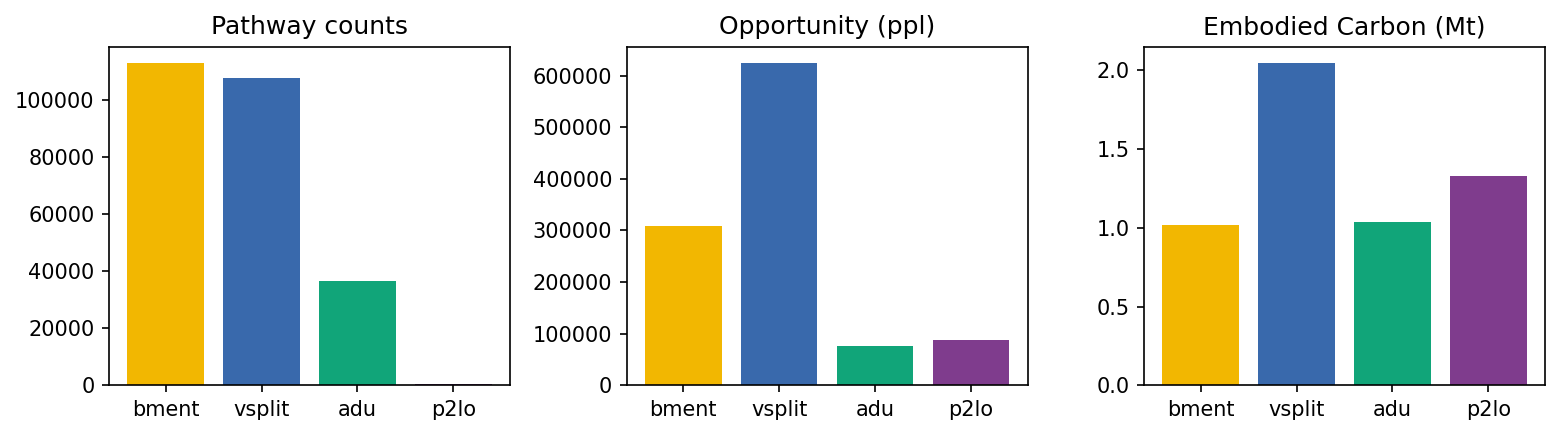

In [61]:
quick_vis_tri(nimby_pids, pathways, cmap)

In [62]:
total_carbon = pathways[pathways["pid"].isin(nimby_pids)]["cost_emb"].sum()/1e9
print(f"Embodied Carbon: {total_carbon:.4} Mt")

Embodied Carbon: 5.433 Mt


In [63]:
with (results_dir / "nimby_pids.pkl").open("wb") as f:
    pickle.dump(nimby_pids, f)

## Historical Proportional
In this scenario, we assume that the population of a given census dissemination area can grow at MOST as fast as it has grown in the past 5 years. The limit is then achieved by extending this growth rate out to 2050, and then picking the minimum of this number we would get if we built at the maximum *existing* density.

### Setup

In [35]:
opt = PathwayOptimizer(pathways)
opt.build_variables()
opt.set_objective(obj_weights)

In [36]:
# Baseline constraints
opt.add_opportunity_constraints(1100000, ">=", tag="min_opp") #Must grow by 1.1 million people
opt.add_mutual_exclusion("p2lo", tag="mutal_exclusion"); #Converting parking lots means you can't do other things in that area

In [37]:
# Historical proportional constraints
c21 = census_data_2021[["1", "6", "geometry"]].copy() # 1: pop, 3: % change 16-21, 6:density
c16 = census_data_2016[["1", "6", "geometry"]].copy() # 1: pop, 3: % change 11-16, 6:density
c16 = c16.rename(columns={"1": "1_2016", "6": "6_2016"})
c16["1_2016"] = c16["1_2016"].astype(float)
c16["6_2016"] = c16["6_2016"].astype(float)

joined = sjoin_greatest_intersection(
    c21.to_crs(proj_crs), 
    c16.to_crs(proj_crs),
    ["1_2016", "6_2016"],
).to_crs("EPSG:4326")

def scaler(col):
    return (col - col.min()) / (col.max() - col.min())

cmap = apply_continuous_cmap(
    values=scaler(joined["1"]-joined["1_2016"].astype(float)),
    cmap = Amp_18,
    alpha = 1
)

polys = PolygonLayer.from_geopandas(
    joined,
    get_fill_color=cmap,
    opacity=1,
    # extruded = True,
    # get_elevation=(joined["1"]-joined["1_2016"])
)

Map([polys], _height=800)

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x000002D58BBCFE80>
[
  [
  …

In [38]:
joined["growth_limit"] = np.maximum(joined["1"] - joined["1_2016"], 0) * (2050-2021)

joined["area"] = joined["geometry"].to_crs(proj_crs).area
joined["density_limit"] = joined["area"] * (joined["1"]/joined["area"]).max()

joined["limit"] = np.minimum(joined["growth_limit"], joined["density_limit"])

opt.add_opportunity_constraints(joined["limit"].to_list(), "<=", joined["geometry"].to_list(), tag="historical");

### Debugging infeas

In [39]:
# Spatial join to map each pathway to a joined geometry
joined_with_hits = gpd.sjoin(joined, pathways[["opportunity", "geometry"]], how="left", predicate="contains")

# Group by joined index and aggregate opportunity
agg = joined_with_hits.groupby(joined_with_hits.index).agg({
    **{col: "first" for col in joined.columns},
    "opportunity": "sum"
})

agg["room"] = np.minimum(np.maximum(agg["limit"],0), agg["opportunity"])
agg["room"].sum()

np.float64(788028.45)

### Solve

In [ ]:
opt.solve(verbose=False)

opt.get_solution_summary()

In [ ]:
hp_pids = opt.get_selected_pids()

cmap = {
    "bment": palette.colors[3],
    "vsplit": palette.colors[2],
    "adu": palette.colors[1],
    "p2lo": palette.colors[0]
}

lonboard_vis(hp_pids, pathways, cmap)

In [ ]:
quick_vis(hp_pids, pathways, cmap)

In [ ]:
total_carbon = pathways[pathways["pid"].isin(hp_pids)]["cost_emb"].sum()/1e9
print(f"Embodied Carbon: {total_carbon:.4} Mt")

In [ ]:
with (results_dir / "hp_pids.pkl").open("wb") as f:
    pickle.dump(hp_pids, f)

## Historical Inversely Proportional
In this scenario, we constrain the fastest-growing, most dense places tighter, and assume that the slowest growing, least_dense places have the most room to grow. In practice this looks like: 

1. Get the growth rates of every DA from 2016-2015 as a percentage of 2016 population
2. Sort DAs by historic growth rate.
3. Assign the Growth rate of `DA[n-i]` to `DA[i]` effectively assigning the highest growth rates to the slowest growing areas

**Note that this one is done using % increase!**

### Setup

In [40]:
opt = PathwayOptimizer(pathways)
opt.build_variables()
opt.set_objective(obj_weights)

In [41]:
# Baseline constraints
opt.add_opportunity_constraints(1100000, ">=", tag="min_opp") #Must grow by 1.1 million people
opt.add_mutual_exclusion("p2lo", tag="mutal_exclusion"); #Converting parking lots means you can't do other things in that area

In [42]:
# Load census data
c21 = census_data_2021[["1", "6", "geometry"]].copy() # 1: pop, 3: % change 16-21, 6:density
c16 = census_data_2016[["1", "6", "geometry"]].copy() # 1: pop, 3: % change 11-16, 6:density
c16 = c16.rename(columns={"1": "1_2016", "6": "6_2016"})
c16["1_2016"] = c16["1_2016"].astype(float)
c16["6_2016"] = c16["6_2016"].astype(float)

joined = sjoin_greatest_intersection(
    c21.to_crs(proj_crs), 
    c16.to_crs(proj_crs),
    ["1_2016", "6_2016"],
).to_crs("EPSG:4326")

In [43]:
# Get proportional change 2016->2021
joined["historical_growth"] = (joined["1"] - joined["1_2016"])/joined["1_2016"]
joined["historical_growth"] = joined["historical_growth"].fillna(0)
joined = joined.sort_values("historical_growth")

# Convert to growth limit
joined["growth_limit"] = joined["historical_growth"].values[::-1]*joined["1_2016"] #reverse order
joined["growth_limit"] = np.maximum(joined["growth_limit"], 0)*(2050-2021)

# Get limit from max current density
joined["area"] = joined["geometry"].to_crs(proj_crs).area
joined["density_limit"] = joined["area"] * (joined["1"]/joined["area"]).max()
joined["limit"] = np.minimum(joined["growth_limit"], joined["density_limit"])

# Add constraint
opt.add_opportunity_constraints(joined["limit"].to_list(), "<=", joined["geometry"].to_list(), tag="historical");

### Debugging Infeas

In [45]:
# Spatial join to map each pathway to a joined geometry
joined_with_hits = gpd.sjoin(joined, pathways[["opportunity", "geometry"]], how="left", predicate="contains")

# Group by joined index and aggregate opportunity
agg = joined_with_hits.groupby(joined_with_hits.index).agg({
    **{col: "first" for col in joined.columns},
    "opportunity": "sum"
})

agg["room"] = np.minimum(np.maximum(agg["limit"],0), agg["opportunity"])
agg["room"].sum()

np.float64(707165.8719607119)

### Solve

In [67]:
opt.model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 5600G with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2644692 - for non-commercial use only - registered to je___@mail.utoronto.ca
Optimize a model with 6591 rows, 822773 columns and 1651124 nonzeros
Model fingerprint: 0x6502cb8d
Variable types: 0 continuous, 822773 integer (822773 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [3e+03, 7e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 4165 rows and 624387 columns
Presolve time: 0.56s

Explored 0 nodes (0 simplex iterations) in 1.11 seconds (0.82 work units)
Thread count was 1 (of 12 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


In [ ]:
opt.solve()

opt.get_solution_summary()

In [ ]:
hip_pids = opt.get_selected_pids()

cmap = {
    "bment": palette.colors[3],
    "vsplit": palette.colors[2],
    "adu": palette.colors[1],
    "p2lo": palette.colors[0]
}

lonboard_vis(hip_pids, pathways, cmap)

In [ ]:
quick_vis(hip_pids, pathways, cmap)

In [ ]:
total_carbon = pathways[pathways["pid"].isin(hip_pids)]["cost_emb"].sum()/1e9
print(f"Embodied Carbon: {total_carbon:.4} Mt")

In [ ]:
with (results_dir / "hip_pids.pkl").open("wb") as f:
    pickle.dump(hip_pids, f)

## Historical Median
Every region can increase population by the median of strictly positively increasing areas from 2016->2021

### Setup

In [12]:
opt = PathwayOptimizer(pathways)
opt.build_variables()
opt.set_objective(obj_weights)

In [13]:
# Baseline constraints
opt.add_opportunity_constraints(1100000, ">=", tag="min_opp") #Must grow by 1.1 million people
opt.add_mutual_exclusion("p2lo", tag="mutal_exclusion"); #Converting parking lots means you can't do other things in that area

In [14]:
# Historical proportional constraints
c21 = census_data_2021[["1", "6", "geometry"]].copy() # 1: pop, 3: % change 16-21, 6:density
c16 = census_data_2016[["1", "6", "geometry"]].copy() # 1: pop, 3: % change 11-16, 6:density
c16 = c16.rename(columns={"1": "1_2016", "6": "6_2016"})
c16["1_2016"] = c16["1_2016"].astype(float)
c16["6_2016"] = c16["6_2016"].astype(float)

joined = sjoin_greatest_intersection(
    c21.to_crs(proj_crs), 
    c16.to_crs(proj_crs),
    ["1_2016", "6_2016"],
).to_crs("EPSG:4326")

Text(0.5, 1.0, 'Histogram of Absolute Growth in Census DAs')

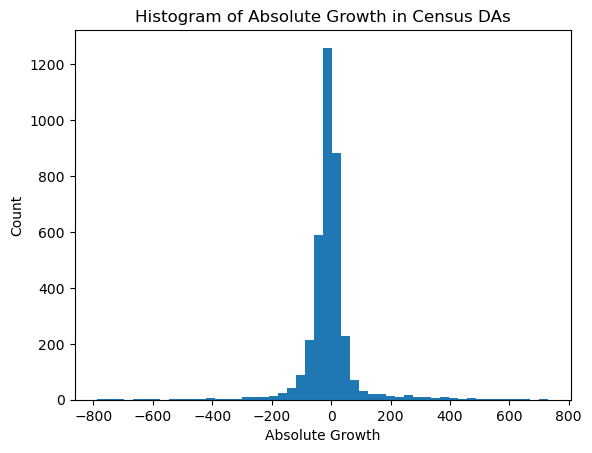

In [15]:
diff = joined["1"] - joined["1_2016"]
filtered = diff[(diff - diff.mean()).abs() <= 2 * diff.std()]
ax = filtered.plot.hist(bins=50)

ax.set_xlabel("Absolute Growth")
ax.set_ylabel("Count")
ax.set_title("Histogram of Absolute Growth in Census DAs")

In [16]:
diff = joined["1"] - joined["1_2016"]
med_positive = diff[diff > 0].median()
print(med_positive)

joined["limit"] = med_positive * (2050-2021)
opt.add_opportunity_constraints(joined["limit"].to_list(), "<=", joined["geometry"].to_list(), tag="historical");

22.0


In [17]:
opt.debug_model(verbose=True)

Gurobi Model Debug Info
- Variables: 843297
- Constraints: 6235
- Objective set: True
- Model status: 1

Objective Weights:
  cost_emb: 1.0

Variables (first 20):
  x_0: not solved
  x_1: not solved
  x_2: not solved
  x_3: not solved
  x_4: not solved
  x_5: not solved
  x_6: not solved
  x_7: not solved
  x_8: not solved
  x_9: not solved
  x_10: not solved
  x_11: not solved
  x_12: not solved
  x_13: not solved
  x_14: not solved
  x_15: not solved
  x_16: not solved
  x_17: not solved
  x_18: not solved
  x_19: not solved
  ... (truncated)

Constraint Tags:
  [min_opp] 1 constraints
  [mutal_exclusion] 2433 constraints
  [historical] 3801 constraints


### Debugging infeas

In [52]:
# Spatial join to map each pathway to a joined geometry
joined_with_hits = gpd.sjoin(joined, pathways[["opportunity", "geometry"]], how="left", predicate="contains")

# Group by joined index and aggregate opportunity
agg = joined_with_hits.groupby(joined_with_hits.index).agg({
    **{col: "first" for col in joined.columns},
    "opportunity": "sum"
})

agg["room"] = np.minimum(np.maximum(agg["limit"],0), agg["opportunity"])
agg["room"].sum()

np.float64(1826863.2000000002)

### Solve

In [18]:
opt.solve()
opt.get_solution_summary()

Optimization Summary
  Objective Value   : 2276369456.16
  Total Opportunity: 1100001.00
  Solve Time        : 14.744 sec
  Selected Pathways : 173868


{'objective_value': 2276369456.157661,
 'cost_column_sums': {'cost_emb': np.float64(2276369456.1576586),
  'cost_bus': np.float64(33585369.77999379),
  'cost_train': np.float64(331123741.9353861),
  'cost_transit': np.float64(695832853.6507661)},
 'total_opportunity': np.float64(1100001.0),
 'solve_time': 14.74399995803833,
 'selected_count': 173868}

In [19]:
hmed_pids = opt.get_selected_pids()

cmap = {
    "bment": palette.colors[3],
    "vsplit": palette.colors[2],
    "adu": palette.colors[1],
    "p2lo": palette.colors[0]
}

lonboard_vis(hmed_pids,
             pathways,
             cmap,
             sample_frac=0.2, 
             layer_kwargs={
                 "opacity":0.2,
                 "radius_scale": 1,
                 # "radius_max_pixels": 2,
                 # "radius_min_pixels": 2,
             },
             map_kwargs={
                 "_height":800
             }
            )

Map(basemap_style=<CartoBasemap.DarkMatterNoLabels: 'https://basemaps.cartocdn.com/gl/dark-matter-nolabels-gl-…

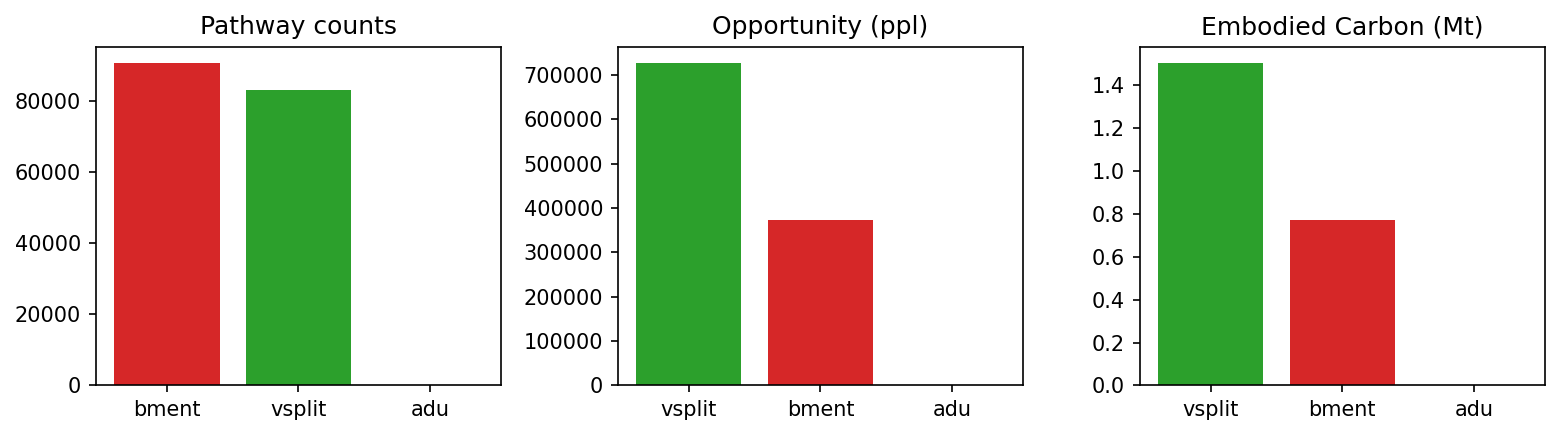

In [20]:
quick_vis_tri(hmed_pids, pathways, cmap)

In [21]:
total_carbon = pathways[pathways["pid"].isin(hmed_pids)]["cost_emb"].sum()/1e9
print(f"Embodied Carbon: {total_carbon:.4} Mt")

Embodied Carbon: 2.276 Mt


In [22]:
with (results_dir / "hmed_pids.pkl").open("wb") as f:
    pickle.dump(hmed_pids, f)

## Smoothed
Every region can increase population by the median of strictly positively increasing areas from 2016->2021

### Setup

In [11]:
opt = PathwayOptimizer(pathways)
opt.build_variables()
opt.set_objective(obj_weights)

In [12]:
# Baseline constraints
opt.add_opportunity_constraints(1100000, ">=", tag="min_opp") #Must grow by 1.1 million people
opt.add_mutual_exclusion("p2lo", tag="mutal_exclusion"); #Converting parking lots means you can't do other things in that area

In [13]:
MAX_DIFF_CHANGE = 2

In [14]:
# Get census data
c21 = census_data_2021[["1", "geometry"]].copy() # 1: pop, 6:density

# Find which areas are adjacent
grph = SpatialGraph.create_from_geoseries(c21["geometry"])

unique_pairs = set()
for node, neighbors in grph.adj_list.items():
    for neighbor in neighbors:
        pair = tuple(sorted((node, neighbor)))
        unique_pairs.add(pair)

unique_pairs = list(unique_pairs)

# Construct input data
geom_pairs = []
limits = []
for ida, idb in unique_pairs:
    geom_pairs.append((c21.at[ida, "geometry"], c21.at[idb, "geometry"]))
    pop_diff = c21.at[ida, "1"] - c21.at[idb, "1"]
    limit = MAX_DIFF_CHANGE * abs(pop_diff) - pop_diff
    limits.append(limit)

In [15]:
opt.add_zone_difference_constraints(geom_pairs, "<=", limits, tag="smoothing")

(<MConstr (12367,)>, <MConstr (12367,)>)

In [16]:
opt.debug_model(verbose=True)

Gurobi Model Debug Info
- Variables: 843297
- Constraints: 27168
- Objective set: True
- Model status: 1

Objective Weights:
  cost_emb: 1.0

Variables (first 20):
  x_0: not solved
  x_1: not solved
  x_2: not solved
  x_3: not solved
  x_4: not solved
  x_5: not solved
  x_6: not solved
  x_7: not solved
  x_8: not solved
  x_9: not solved
  x_10: not solved
  x_11: not solved
  x_12: not solved
  x_13: not solved
  x_14: not solved
  x_15: not solved
  x_16: not solved
  x_17: not solved
  x_18: not solved
  x_19: not solved
  ... (truncated)

Constraint Tags:
  [min_opp] 1 constraints
  [mutal_exclusion] 2433 constraints
  [smoothing_1] 12367 constraints
  [smoothing_2] 12367 constraints


### Solve

In [17]:
opt.solve(verbose=True)
opt.get_solution_summary()

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 5600G with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2644692 - for non-commercial use only - registered to je___@mail.utoronto.ca
Optimize a model with 27168 rows, 843297 columns and 12560811 nonzeros
Model fingerprint: 0x8dffe5e1
Variable types: 0 continuous, 843297 integer (843297 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [3e+03, 7e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 9197 rows and 261640 columns (presolve time = 5s)...
Presolve removed 9431 rows and 260232 columns
Presolve time: 8.89s
Presolved: 17737 rows, 583065 columns, 736191 nonzeros
Variable types: 0 continuous, 583065 integer (572878 binary)
Deterministic concurrent LP optimizer: primal simp

{'objective_value': 2413534769.0592055,
 'cost_column_sums': {'cost_emb': np.float64(2413534769.059207),
  'cost_bus': np.float64(34137567.91645349),
  'cost_train': np.float64(334462248.6582606),
  'cost_transit': np.float64(703062065.2329746)},
 'total_opportunity': np.float64(1100001.0000000005),
 'solve_time': 871.6979999542236,
 'selected_count': 180826}

In [18]:
smooth_pids = opt.get_selected_pids()

cmap = {
    "bment": palette.colors[3],
    "vsplit": palette.colors[2],
    "adu": palette.colors[1],
    "p2lo": palette.colors[0]
}

lonboard_vis(smooth_pids,
             pathways,
             cmap,
             sample_frac=0.2, 
             layer_kwargs={
                 "opacity":0.2,
                 "radius_scale": 1,
                 # "radius_max_pixels": 2,
                 # "radius_min_pixels": 2,
             },
             map_kwargs={
                 "_height":800
             }
            )

Map(basemap_style=<CartoBasemap.DarkMatterNoLabels: 'https://basemaps.cartocdn.com/gl/dark-matter-nolabels-gl-…

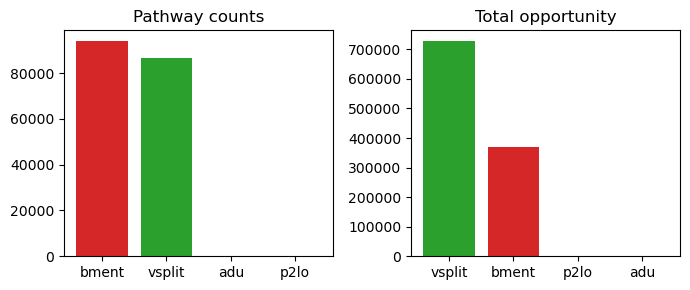

In [19]:
quick_vis(smooth_pids, pathways, cmap)

In [20]:
total_carbon = pathways[pathways["pid"].isin(smooth_pids)]["cost_emb"].sum()/1e9
print(f"Embodied Carbon: {total_carbon:.4} Mt")

Embodied Carbon: 2.414 Mt


In [21]:
with (results_dir / "smooth_pids.pkl").open("wb") as f:
    pickle.dump(smooth_pids, f)

## Max Conversion
In this example, I set a limit on the amount of SFH that can be converted.

### Setup

In [68]:
opt = PathwayOptimizer(pathways)
opt.build_variables()
opt.set_objective(obj_weights)

In [69]:
# Baseline constraints
opt.add_opportunity_constraints(1100000, ">=", tag="min_opp") #Must grow by 1.1 million people
opt.add_mutual_exclusion("p2lo", tag="mutal_exclusion"); #Converting parking lots means you can't do other things in that area

In [71]:
opt.add_conversion_constraints(
    start_name="sfh",
    sense="<=",
    limit=30000,
    check_overlaps = True,
    proj_crs="EPSG:3347",
    debuff=1,
    tag="overlaps"
)

<gurobi.Constr R2434>

In [53]:
opt.export_model("test.lp")

Model written to: test.lp.lp


In [73]:
opt.debug_model(verbose=True)

Gurobi Model Debug Info
- Variables: 1117048
- Constraints: 276186
- Objective set: True
- Model status: 1

Objective Weights:
  cost_emb: 1.0

Variables (first 20):
  x_0: not solved
  x_1: not solved
  x_2: not solved
  x_3: not solved
  x_4: not solved
  x_5: not solved
  x_6: not solved
  x_7: not solved
  x_8: not solved
  x_9: not solved
  x_10: not solved
  x_11: not solved
  x_12: not solved
  x_13: not solved
  x_14: not solved
  x_15: not solved
  x_16: not solved
  x_17: not solved
  x_18: not solved
  x_19: not solved
  ... (truncated)

Constraint Tags:
  [min_opp] 1 constraints
  [mutal_exclusion] 2433 constraints
  [overlaps_dummy] 273751 constraints
  [overlaps] 1 constraints


### Solve

In [74]:
opt.solve(verbose=True)
opt.get_solution_summary()

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700K, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Academic license 2644692 - for non-commercial use only - registered to je___@mail.utoronto.ca
Optimize a model with 2435 rows, 1117048 columns and 1141793 nonzeros
Model fingerprint: 0xc6e6832c
Model has 273751 simple general constraints
  273751 OR
Variable types: 0 continuous, 1117048 integer (1117048 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [3e+03, 7e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve added 547509 rows and 0 columns
Presolve removed 0 rows and 268830 columns
Presolve time: 3.41s
Presolved: 549944 rows, 848218 columns, 1948111 nonzeros
Variable types: 0 continuous, 848218 integer (848212 binary)
Found heuristic solution

{'objective_value': 10406236779.551119,
 'cost_column_sums': {'cost_emb': np.float64(10406236779.551128),
  'cost_bus': np.float64(64851551.756020986),
  'cost_train': np.float64(626539562.592344),
  'cost_transit': np.float64(1317930676.9407089),
  'cost_access': np.float64(208843.92527256825)},
 'total_opportunity': np.float64(1100002.0499999998),
 'solve_time': 19.23300004005432,
 'selected_count': 331132}

In [75]:
mconv_pids = opt.get_selected_pids()

cmap = {
    "bment": palette.colors[3],
    "vsplit": palette.colors[2],
    "adu": palette.colors[1],
    "p2lo": palette.colors[0]
}

lonboard_vis(mconv_pids,
             pathways,
             cmap,
             sample_frac=0.2, 
             layer_kwargs={
                 "opacity":0.2,
                 "radius_scale": 1,
                 # "radius_max_pixels": 2,
                 # "radius_min_pixels": 2,
             },
             map_kwargs={
                 "_height":800
             }
            )

Map(basemap_style=<CartoBasemap.DarkMatterNoLabels: 'https://basemaps.cartocdn.com/gl/dark-matter-nolabels-gl-…

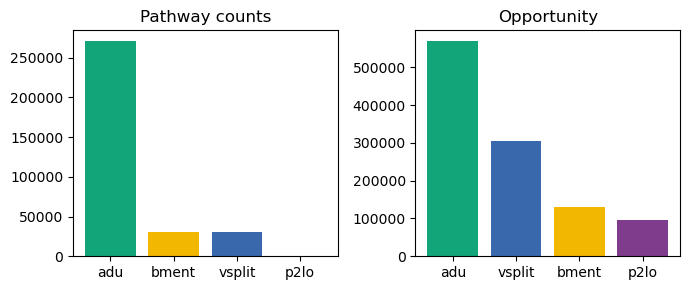

In [76]:
quick_vis(mconv_pids, pathways, cmap)

In [77]:
total_carbon = pathways[pathways["pid"].isin(mconv_pids)]["cost_emb"].sum()/1e9
print(f"Embodied Carbon: {total_carbon:.4} Mt")

Embodied Carbon: 10.41 Mt


In [78]:
with (results_dir / "mconv_pids.pkl").open("wb") as f:
    pickle.dump(mconv_pids, f)

# MOO

## cost_emb vs cost_acc

### Setup

In [18]:
cost_cols = ["cost_emb", "cost_access"]
scaler = [1, 10000]

In [19]:
opt = PathwayOptimizer(pathways)
opt.build_variables()

# Baseline constraints
opt.add_opportunity_constraints(1100000, ">=", tag="min_opp") #Must grow by 1.1 million people
opt.add_mutual_exclusion("p2lo", tag="mutal_exclusion") #Converting parking lots means you can't do other things in that area

# Generic Constraints
cdata = census_data_2021[["1", "geometry"]].copy() # 1: 2021 population, 243: Median HH income

cdata["limit"] = cdata["1"] * 2

# opt.add_opportunity_constraints(cdata["limit"].to_list(), "<=", cdata["geometry"].to_list(), tag="doubling");

### Solve

In [20]:
opt.data.sample(5)

,label,start,end,desc,opportunity,geometry,cost_emb,cost_bus,cost_train,cost_transit,cost_access,pid
783993,bment,sfh,multiplex,Adding a basement unit to a single family home,2.10,"POLYGON ((-79.38168 43.803, -79.38174 43.80286...",7975.308955,358.356894,3724.919694,7808.196282,0.528702,783993
496280,vsplit,sfh,multiplex,Vertically splitting a multi-story SFH into ne...,6.30,"POLYGON ((-79.55236 43.72068, -79.55236 43.720...",22191.444954,399.392295,7117.132490,14633.657275,0.660932,496280
817357,bment,sfh,multiplex,Adding a basement unit to a single family home,3.15,"POLYGON ((-79.25943 43.81156, -79.25951 43.811...",9991.868040,75.128634,8232.401735,16539.932104,0.733277,817357
32084,adu,backyard,sfh,Adding an additional dwelling unit to on a sin...,2.10,"POLYGON ((-79.39696 43.68962, -79.39703 43.689...",28224.000000,154.789057,259.855679,674.500414,0.318508,32084
249358,adu,backyard,sfh,Adding an additional dwelling unit to on a sin...,2.10,"POLYGON ((-79.41602 43.73486, -79.41604 43.734...",28224.000000,324.056532,1250.521172,2825.098877,0.570238,249358


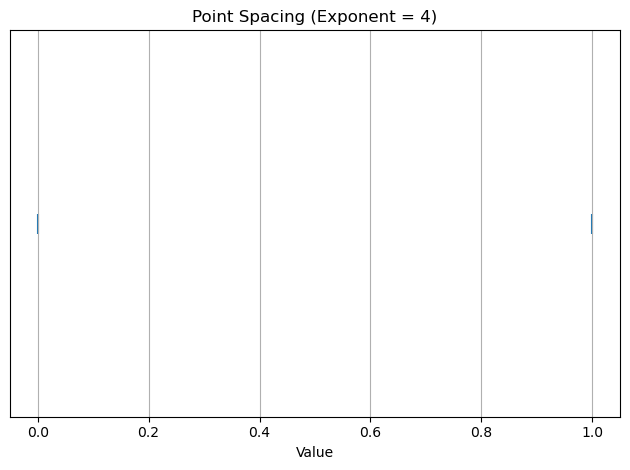

In [22]:
import numpy as np
import matplotlib.pyplot as plt

n_points = 2
exponent = 4
start = 1.0
end = 0.00

points = start + (end - start) * (np.linspace(0, 1, n_points) ** exponent)

plt.scatter(points, [1]*n_points, marker='|', s=200)
plt.yticks([])
plt.title(f"Point Spacing (Exponent = {exponent})")
plt.xlabel("Value")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

weights = [[p, 1-p] for p in points]

In [23]:
output = []
pid_saves = []

In [24]:
for w in weights:
    obj_weights = {c: w[i]*scaler[i] for i, c in enumerate(cost_cols)}
    print(obj_weights)
    opt.set_objective(obj_weights)
    opt.solve(verbose=False)

    selected_pids = opt.get_selected_pids()
    pid_saves.append((w[0], w[1], selected_pids))

    # if prev_pids is not None:
    #     assert set(selected_pids) != set(prev_pids), "selected_pids did not change"


    # Get results for ALL objectives in the dataset
    # (not just specified cost columns)
    # selected_pids = opt.get_selected_pids()
    built = opt.data[opt.data["pid"].isin(selected_pids)].copy()

    obj_vals = [built[c].sum() for c in opt.cost_columns]
    median_costs = [
        weighted_median(built[c], built["opportunity"]) for c in opt.cost_columns
    ]

    # Construct output data
    row = {f"weight_{c}": obj_weights[c] for c in cost_cols}
    for c in opt.cost_columns:
        row[c] = built[c].sum()
        row[f"{c}_median"] = weighted_median(built[c], built["opportunity"])

    output.append(row)

{'cost_emb': np.float64(1.0), 'cost_access': np.float64(0.0)}
Optimization Summary
  Objective Value   : 3247782332.39
  Total Opportunity: 1100001.00
  Solve Time        : 5.058 sec
  Selected Pathways : 212931
{'cost_emb': np.float64(0.0), 'cost_access': np.float64(10000.0)}
Optimization Summary
  Objective Value   : 461162310.21
  Total Opportunity: 1100006.25
  Solve Time        : 8.024 sec
  Selected Pathways : 83411


In [25]:
df = pd.DataFrame(output)
df = df.sort_values("weight_cost_emb")
df["cost_emb"] = df["cost_emb"]/(1e9*scaler[0])
df["cost_access"] = df["cost_access"]/scaler[1]

In [26]:
df

,weight_cost_emb,weight_cost_access,cost_emb,cost_emb_median,cost_bus,cost_bus_median,cost_train,cost_train_median,cost_transit,cost_transit_median,cost_access,cost_access_median
1,0.0,10000.0,8.800394,36917.661223,1.586327e+07,138.544635,1.712664e+08,1988.810446,3.583961e+08,4142.097481,4.611623,0.607520
0,1.0,0.0,3.247782,18272.685458,4.388741e+07,182.322548,7.563214e+08,2617.034294,1.556530e+09,5445.510239,13.670211,0.650151


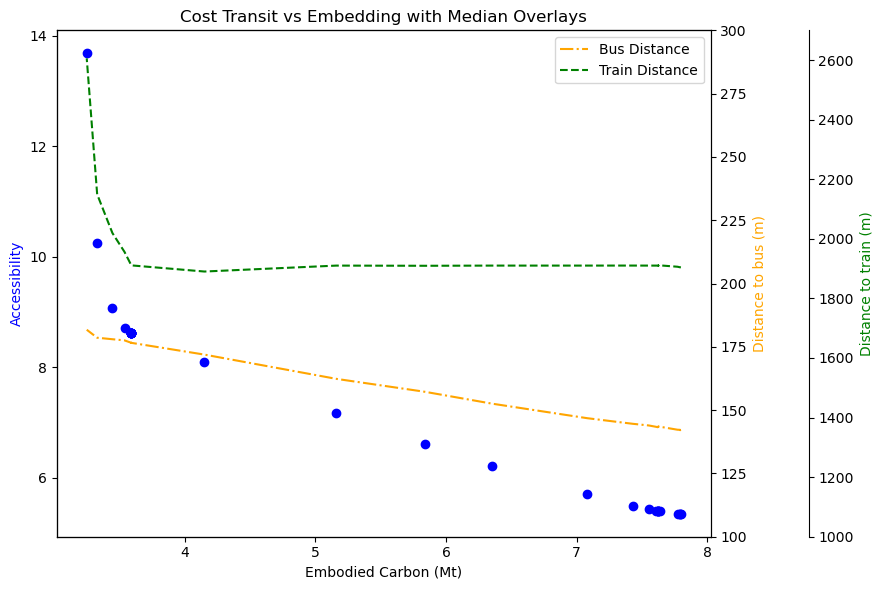

In [168]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(9, 6))

# Primary y-axis: cost_transit
ax1.scatter(df['cost_emb'], df['cost_access'], color="blue", label='Pareto Front')
ax1.set_xlabel('Embodied Carbon (Mt)')
ax1.set_ylabel('Accessibility', color="blue")
ax1.tick_params(axis='y')

# Secondary axes: side-by-side on the right
ax2_low = ax1.twinx()
ax2_high = ax1.twinx()
ax2_high.spines["right"].set_position(("axes", 1.15))  # shift to avoid overlap
ax2_high.spines["right"].set_visible(True)

# Plot median curves
ax2_low.plot(df['cost_emb'], df['cost_bus_median'], color='orange', linestyle='-.', label='Bus Distance')
ax2_high.plot(df['cost_emb'], df['cost_train_median'], color='green', linestyle='--', label='Train Distance')

# Set limits
ax2_low.set_ylim(100, 300)
ax2_high.set_ylim(1000, 2700)

# Tick config
ax2_low.tick_params(labelright=True, right=True)
ax2_high.tick_params(labelright=True, right=True)

# Independent y-axis labels
ax2_low.set_ylabel('Distance to bus (m)', color='orange')
ax2_high.set_ylabel('Distance to train (m)', color='green')

# Combine legends
lines1, labels1 = ax2_low.get_legend_handles_labels()
lines2, labels2 = ax2_high.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title("Cost Transit vs Embedding with Median Overlays")
plt.tight_layout()
plt.show()


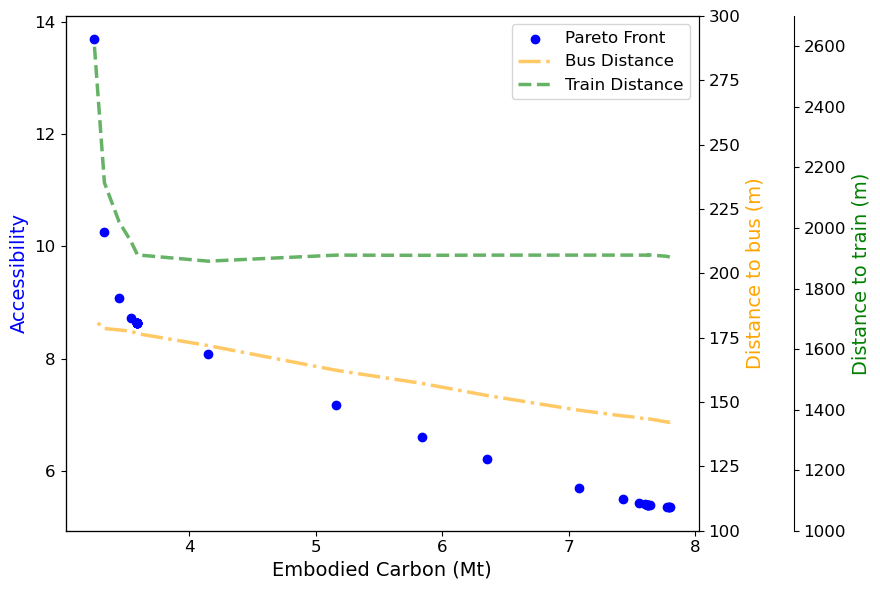

In [170]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(9, 6))

# Primary y-axis: cost_transit
scatter = ax1.scatter(df['cost_emb'], df['cost_access'], color="blue", label='Pareto Front')
ax1.set_xlabel('Embodied Carbon (Mt)', fontsize=14)
ax1.set_ylabel('Accessibility', color="blue", fontsize=14)
ax1.tick_params(axis='both', labelsize=12)

# Secondary axes
ax2_low = ax1.twinx()
ax2_high = ax1.twinx()
ax2_high.spines["right"].set_position(("axes", 1.15))
ax2_high.spines["right"].set_visible(True)

# Plot faded, wider lines
line1, = ax2_low.plot(df['cost_emb'], df['cost_bus_median'],
                      color='orange', linestyle='-.', linewidth=2.5, alpha=0.6, label='Bus Distance')
line2, = ax2_high.plot(df['cost_emb'], df['cost_train_median'],
                       color='green', linestyle='--', linewidth=2.5, alpha=0.6, label='Train Distance')

# Set axis limits
ax2_low.set_ylim(100, 300)
ax2_high.set_ylim(1000, 2700)

# Tick config
ax2_low.tick_params(labelright=True, right=True, labelsize=12)
ax2_high.tick_params(labelright=True, right=True, labelsize=12)

# Axis labels
ax2_low.set_ylabel('Distance to bus (m)', color='orange', fontsize=14)
ax2_high.set_ylabel('Distance to train (m)', color='green', fontsize=14)

# Combine legends
lines0, labels0 = [scatter], ['Pareto Front']
lines1, labels1 = ax2_low.get_legend_handles_labels()
lines2, labels2 = ax2_high.get_legend_handles_labels()
ax1.legend(lines0 + lines1 + lines2, labels0 + labels1 + labels2, loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()


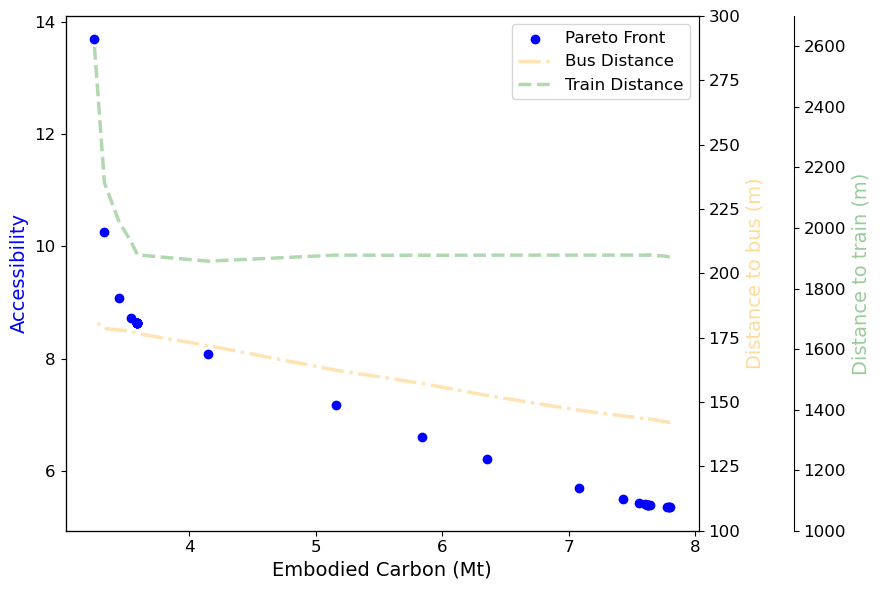

In [175]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(9, 6))

# Pareto front
scatter = ax1.scatter(df['cost_emb'], df['cost_access'], color="blue", label='Pareto Front')
ax1.set_xlabel('Embodied Carbon (Mt)', fontsize=14)
ax1.set_ylabel('Accessibility', color="blue", fontsize=14)
ax1.tick_params(axis='both', labelsize=12)

# Secondary axes
ax2_low = ax1.twinx()
ax2_high = ax1.twinx()
ax2_high.spines["right"].set_position(("axes", 1.15))
ax2_high.spines["right"].set_visible(True)

# Plot faded, wider lines
line1, = ax2_low.plot(df['cost_emb'], df['cost_bus_median'],
                      color='orange', linestyle='-.', linewidth=2.5, alpha=0.3, label='Bus Distance')
line2, = ax2_high.plot(df['cost_emb'], df['cost_train_median'],
                       color='green', linestyle='--', linewidth=2.5, alpha=0.3, label='Train Distance')

# Set axis limits
ax2_low.set_ylim(100, 300)
ax2_high.set_ylim(1000, 2700)

# Combine legends
lines0, labels0 = [scatter], ['Pareto Front']
lines1, labels1 = ax2_low.get_legend_handles_labels()
lines2, labels2 = ax2_high.get_legend_handles_labels()
ax1.legend(lines0 + lines1 + lines2, labels0 + labels1 + labels2, loc='upper right', fontsize=12)

# Light transparent colors
faded_orange = (1.0, 0.65, 0.0, 0.4)
faded_green = (0.0, 0.5, 0.0, 0.4)

# Apply to y-axis tick labels and lines
ax2_low.tick_params(labelright=True, right=True, labelsize=12)
ax2_high.tick_params(labelright=True, right=True, labelsize=12)

ax2_low.set_ylabel('Distance to bus (m)', fontsize=14, color=faded_orange)
ax2_high.set_ylabel('Distance to train (m)', fontsize=14, color=faded_green)
plt.tight_layout()
plt.show()


In [27]:
df.to_csv("moo2.csv")

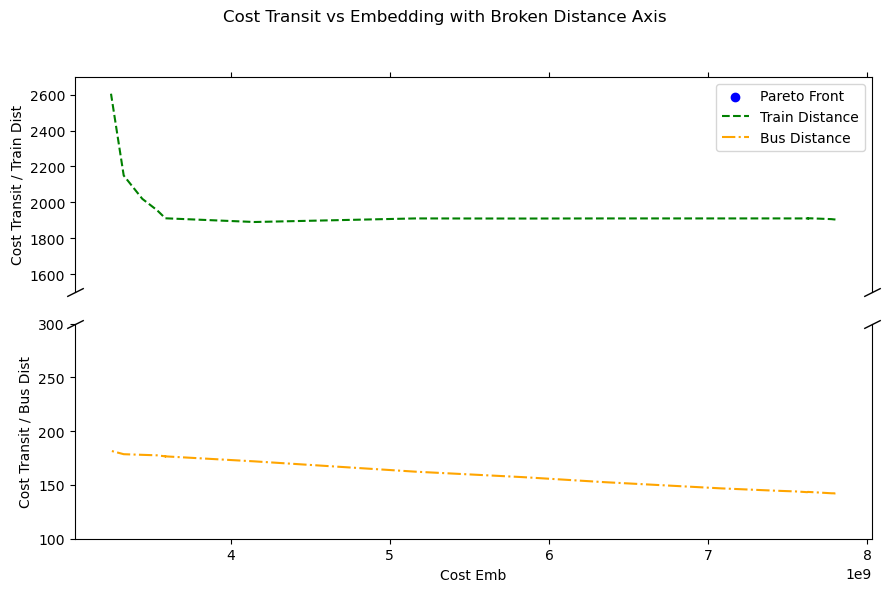

In [154]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9, 6), gridspec_kw={'height_ratios': [1, 1]})
fig.subplots_adjust(hspace=0.05)

# Pareto front on both axes
ax1.scatter(df['cost_emb'], df['cost_access'], color='blue', label='Pareto Front')
ax2.scatter(df['cost_emb'], df['cost_access'], color='blue')

# Train distance on upper (high range)
ax1.plot(df['cost_emb'], df['cost_train_median'], color='green', linestyle='--', label='Train Distance')
ax1.set_ylim(1500, 2700)

# Bus distance on lower (low range)
ax2.plot(df['cost_emb'], df['cost_bus_median'], color='orange', linestyle='-.', label='Bus Distance')
ax2.set_ylim(100, 300)

# Axis labels
ax2.set_xlabel('Cost Emb')
ax1.set_ylabel('Cost Transit / Train Dist')
ax2.set_ylabel('Cost Transit / Bus Dist')

# Hide spines
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()
ax1.xaxis.tick_top()

# Break lines
d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# Legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.suptitle("Cost Transit vs Embedding with Broken Distance Axis")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [28]:
with Path("moo2_pids.pkl").open("wb") as f:
    pickle.dump(pid_saves, f)

In [29]:
with Path("moo2_pids.pkl").open("rb") as f:
    test = pickle.load(f)